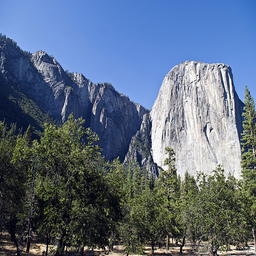

In [4]:
from PIL import Image

img = Image.open("data/cyclegan/summer2winter_yosemite/testA/2010-10-05 13:45:11.jpg")
img

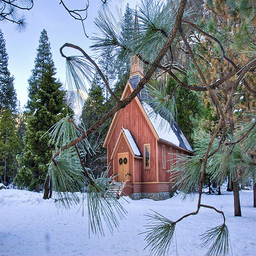

In [12]:
img = Image.open("data/cyclegan/summer2winter_yosemite/trainB/2008-02-03 19:31:33.jpg")
img

In [30]:
import numpy as np
np.array(img).shape

(256, 256, 3)

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransformerPositionalEmbedding(nn.Module):
    """
    From paper "Attention Is All You Need", section 3.5
    """
    def __init__(self, dimension, max_timesteps=1000, device="cuda"):
        super(TransformerPositionalEmbedding, self).__init__()
        assert dimension % 2 == 0, "Embedding dimension must be even"
        self.dimension = dimension
        self.pe_matrix = torch.zeros(max_timesteps, dimension).to(device)
        # Gather all the even dimensions across the embedding vector
        even_indices = torch.arange(0, self.dimension, 2)
        # Calculate the term using log transforms for faster calculations
        # (https://stackoverflow.com/questions/17891595/pow-vs-exp-performance)
        log_term = torch.log(torch.tensor(10000.0)) / self.dimension
        div_term = torch.exp(even_indices * -log_term)

        # Precompute positional encoding matrix based on odd/even timesteps
        timesteps = torch.arange(max_timesteps).unsqueeze(1)
        self.pe_matrix[:, 0::2] = torch.sin(timesteps * div_term)
        self.pe_matrix[:, 1::2] = torch.cos(timesteps * div_term)

    def forward(self, timestep):
        # [bs, d_model]
        # return self.pe_matrix[timestep].to(timestep.device)
        return self.pe_matrix[timestep].to("cuda")


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(DownsampleBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=padding)

    def forward(self, input_tensor):
        x = self.conv(input_tensor)
        return x


class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2.0):
        super(UpsampleBlock, self).__init__()

        self.scale = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)

    def forward(self, input_tensor):
        # align_corners=True for potential convertibility to ONNX
        x = F.interpolate(input_tensor, scale_factor=self.scale, mode="bilinear", align_corners=True)
        x = self.conv(x)
        return x


class ConvDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, time_emb_channels, num_groups, downsample=True):
        super(ConvDownBlock, self).__init__()
        resnet_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            resnet_blocks.append(resnet_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)

        self.downsample = DownsampleBlock(in_channels=out_channels, out_channels=out_channels, stride=2, padding=1) \
            if downsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block in self.resnet_blocks:
            x = resnet_block(x, time_embedding)
        if self.downsample:
            x = self.downsample(x)
        return x


class ConvUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, time_emb_channels, num_groups, upsample=True):
        super(ConvUpBlock, self).__init__()
        resnet_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            resnet_blocks.append(resnet_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)

        self.upsample = UpsampleBlock(in_channels=out_channels, out_channels=out_channels) \
            if upsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block in self.resnet_blocks:
            x = resnet_block(x, time_embedding)
        if self.upsample:
            x = self.upsample(x)
        return x


class SelfAttentionBlock(nn.Module):
    """
    Self-attention blocks are applied at the 16x16 resolution in the original DDPM paper.
    Implementation is based on "Attention Is All You Need" paper, Vaswani et al., 2015
    (https://arxiv.org/pdf/1706.03762.pdf)
    """
    def __init__(self, num_heads, in_channels, num_groups=32, embedding_dim=256):
        super(SelfAttentionBlock, self).__init__()
        # For each of heads use d_k = d_v = d_model / num_heads
        self.num_heads = num_heads
        self.d_model = embedding_dim
        self.d_keys = embedding_dim // num_heads
        self.d_values = embedding_dim // num_heads

        self.query_projection = nn.Linear(in_channels, embedding_dim)
        self.key_projection = nn.Linear(in_channels, embedding_dim)
        self.value_projection = nn.Linear(in_channels, embedding_dim)

        self.final_projection = nn.Linear(embedding_dim, embedding_dim)
        self.norm = nn.GroupNorm(num_channels=embedding_dim, num_groups=num_groups)

    def split_features_for_heads(self, tensor):
        # We receive Q, K and V at shape [batch, h*w, embedding_dim].
        # This method splits embedding_dim into 'num_heads' features so that
        # each channel becomes of size embedding_dim / num_heads.
        # Output shape becomes [batch, num_heads, h*w, embedding_dim/num_heads],
        # where 'embedding_dim/num_heads' is equal to d_k = d_k = d_v = sizes for
        # K, Q and V respectively, according to paper.
        batch, hw, emb_dim = tensor.shape
        channels_per_head = emb_dim // self.num_heads
        heads_splitted_tensor = torch.split(tensor, split_size_or_sections=channels_per_head, dim=-1)
        heads_splitted_tensor = torch.stack(heads_splitted_tensor, 1)
        return heads_splitted_tensor

    def forward(self, input_tensor):
        x = input_tensor
        batch, features, h, w = x.shape
        # Do reshape and transpose input tensor since we want to process depth feature maps, not spatial maps
        x = x.view(batch, features, h * w).transpose(1, 2)

        # Get linear projections of K, Q and V according to Fig. 2 in the original Transformer paper
        queries = self.query_projection(x)  # [b, in_channels, embedding_dim]
        keys = self.key_projection(x)       # [b, in_channels, embedding_dim]
        values = self.value_projection(x)   # [b, in_channels, embedding_dim]

        # Split Q, K, V between attention heads to process them simultaneously
        queries = self.split_features_for_heads(queries)
        keys = self.split_features_for_heads(keys)
        values = self.split_features_for_heads(values)

        # Perform Scaled Dot-Product Attention (eq. 1 in the Transformer paper).
        # Each SDPA block yields tensor of size d_v = embedding_dim/num_heads.
        scale = self.d_keys ** -0.5
        attention_scores = torch.softmax(torch.matmul(queries, keys.transpose(-1, -2)) * scale, dim=-1)
        attention_scores = torch.matmul(attention_scores, values)

        # Permute computed attention scores such that
        # [batch, num_heads, h*w, embedding_dim] --> [batch, h*w, num_heads, d_v]
        attention_scores = attention_scores.permute(0, 2, 1, 3).contiguous()

        # Concatenate scores per head into one tensor so that
        # [batch, h*w, num_heads, d_v] --> [batch, h*w, num_heads*d_v]
        concatenated_heads_attention_scores = attention_scores.view(batch, h * w, self.d_model)

        # Perform linear projection and reshape tensor such that
        # [batch, h*w, d_model] --> [batch, d_model, h*w] -> [batch, d_model, h, w]
        linear_projection = self.final_projection(concatenated_heads_attention_scores)
        linear_projection = linear_projection.transpose(-1, -2).reshape(batch, self.d_model, h, w)

        # Residual connection + norm
        x = self.norm(linear_projection + input_tensor)
        return x


class AttentionDownBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_layers,
                 time_emb_channels,
                 num_groups,
                 num_att_heads,
                 downsample=True):
        """
        AttentionDownBlock consists of ResNet blocks with Self-Attention blocks in-between
        :param in_channels:
        :param out_channels:
        :param num_layers:
        :param time_emb_channels:
        :param num_groups:
        :param num_att_heads:
        :param downsample:
        """
        super(AttentionDownBlock, self).__init__()

        resnet_blocks = []
        attention_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            attention_block = SelfAttentionBlock(in_channels=out_channels,
                                                 embedding_dim=out_channels,
                                                 num_heads=num_att_heads,
                                                 num_groups=num_groups)

            resnet_blocks.append(resnet_block)
            attention_blocks.append(attention_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)

        self.downsample = DownsampleBlock(in_channels=out_channels, out_channels=out_channels, stride=2, padding=1) \
            if downsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block, attention_block in zip(self.resnet_blocks, self.attention_blocks):
            x = resnet_block(x, time_embedding)
            x = attention_block(x)
        if self.downsample:
            x = self.downsample(x)
        return x


class AttentionUpBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_layers,
                 time_emb_channels,
                 num_groups,
                 num_att_heads,
                 upsample=True):
        """
        :param in_channels:
        :param out_channels:
        :param num_layers:
        :param time_emb_channels:
        :param num_groups:
        :param num_att_heads:
        :param upsample:
        """
        super(AttentionUpBlock, self).__init__()

        resnet_blocks = []
        attention_blocks = []
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnet_block = ResNetBlock(in_channels=in_channels,
                                       out_channels=out_channels,
                                       time_emb_channels=time_emb_channels,
                                       num_groups=num_groups)
            attention_block = SelfAttentionBlock(in_channels=out_channels,
                                                 embedding_dim=out_channels,
                                                 num_heads=num_att_heads,
                                                 num_groups=num_groups)

            resnet_blocks.append(resnet_block)
            attention_blocks.append(attention_block)

        self.resnet_blocks = nn.ModuleList(resnet_blocks)
        self.attention_blocks = nn.ModuleList(attention_blocks)

        self.upsample = UpsampleBlock(in_channels=out_channels, out_channels=out_channels) \
            if upsample \
            else None

    def forward(self, input_tensor, time_embedding):
        x = input_tensor
        for resnet_block, attention_block in zip(self.resnet_blocks, self.attention_blocks):
            x = resnet_block(x, time_embedding)
            x = attention_block(x)
        if self.upsample:
            x = self.upsample(x)
        return x


class ResNetBlock(nn.Module):
    """
    In the original DDPM paper Wide ResNet was used
    (https://arxiv.org/pdf/1605.07146.pdf).
    """
    def __init__(self, in_channels, out_channels, *, time_emb_channels=None, num_groups=8):
        super(ResNetBlock, self).__init__()
        self.time_embedding_projectile = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_channels, out_channels))
            if time_emb_channels
            else None
        )

        self.block1 = ConvBlock(in_channels, out_channels, groups=num_groups)
        self.block2 = ConvBlock(out_channels, out_channels, groups=num_groups)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, time_embedding=None):
        input_tensor = x
        h = self.block1(x)
        # According to authors implementations, they inject timestep embedding into the network
        # using MLP after the first conv block in all the ResNet blocks
        # (https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L49)

        time_emb = self.time_embedding_projectile(time_embedding)
        time_emb = time_emb[:, :, None, None]
        x = time_emb + h

        x = self.block2(x)
        return x + self.residual_conv(input_tensor)


In [55]:
class UNet(nn.Module):
    """
    Model architecture as described in the DDPM paper, Appendix, section B
    """

    def __init__(self, image_size=256, input_channels=3, device="cuda"):
        super().__init__()
        # 1. We replaced weight normalization with group normalization
        # 2. Our 32x32 models use four feature map resolutions (32x32 to 4x4), and our 256x256 models use six (I made 5)
        # 3. Two convolutional residual blocks per resolution level and self-attention blocks at the 16x16 resolution
        # between the convolutional blocks [https://arxiv.org/pdf/1712.09763.pdf]
        # 4. Diffusion time t is specified by adding the Transformer sinusoidal position embedding into
        # each residual block [https://arxiv.org/pdf/1706.03762.pdf]

        self.initial_conv = nn.Conv2d(in_channels=input_channels, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.positional_encoding = nn.Sequential(
            TransformerPositionalEmbedding(dimension=128, device=device),
            nn.Linear(128, 128 * 4),
            nn.GELU(),
            nn.Linear(128 * 4, 128 * 4)
        )

        self.downsample_blocks = nn.ModuleList([
            ConvDownBlock(in_channels=128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=128, out_channels=256, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            AttentionDownBlock(in_channels=256, out_channels=256, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128 * 4),
            ConvDownBlock(in_channels=256, out_channels=512, num_layers=2, num_groups=32, time_emb_channels=128 * 4)
        ])

        self.bottleneck = AttentionDownBlock(in_channels=512, out_channels=512, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128*4, downsample=False)                                                                                                  # 16x16x256 -> 16x16x256

        self.upsample_blocks = nn.ModuleList([
            ConvUpBlock(in_channels=512 + 512, out_channels=512, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            AttentionUpBlock(in_channels=512 + 256, out_channels=256, num_layers=2, num_att_heads=4, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=256 + 256, out_channels=256, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=256 + 128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4),
            ConvUpBlock(in_channels=128 + 128, out_channels=128, num_layers=2, num_groups=32, time_emb_channels=128 * 4)
        ])

        self.output_conv = nn.Sequential(
            nn.GroupNorm(num_channels=256, num_groups=32),
            nn.SiLU(),
            nn.Conv2d(256, 3, 3, padding=1)
        )

    def forward(self, input_tensor, time):
        time_encoded = self.positional_encoding(time)

        initial_x = self.initial_conv(input_tensor)

        states_for_skip_connections = [initial_x]

        x = initial_x
        for i, block in enumerate(self.downsample_blocks):
            x = block(x, time_encoded)
            states_for_skip_connections.append(x)
        states_for_skip_connections = list(reversed(states_for_skip_connections))

        x = self.bottleneck(x, time_encoded)

        for i, (block, skip) in enumerate(zip(self.upsample_blocks, states_for_skip_connections)):
            x = torch.cat([x, skip], dim=1)
            x = block(x, time_encoded)

        # Concat initial_conv with tensor
        x = torch.cat([x, states_for_skip_connections[-1]], dim=1)
        # Get initial shape [3, 256, 256] with convolutions
        out = self.output_conv(x)

        return out


In [57]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch import optim
from utils import *


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        print(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x


def train(args):
    device = args.device
    dataloader = get_data(args)
    model = UNet(image_size=256, input_channels=3).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    l = len(dataloader)

    for epoch in range(args.epochs):
        print(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            # print(f"MSE: {loss.item()} Global Step: {epoch * l + i}")

        sampled_images = diffusion.sample(model, n=images.shape[0])
        # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        save_images(sampled_images, f"/nfshomes/skarki/scratch/personalized-llm/src/ddpm/results/DDPM_Unconditional/{epoch}.jpg")
        torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


# class TrainerArgs:
#     def __init__(self,
#                  run_name="DDPM_Uncondtional",
#                  epochs=100,
#                  batch_size=8,
#                  image_size=256,
#                  dataset_path="data/cyclegan/summer2winter_yosemite/train",
#                  device="cuda",
#                  lr = 3e-4
#                 ):
#         self.run_name = run_name
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.image_size = image_size
#         self.dataset_path = dataset_path
#         self.device = device
#         self.lr = lr


# arguments = TrainerArgs()
# train(arguments)


Starting epoch 0:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'results/DDPM_Uncondtional/0.jpg'

In [61]:
args = TrainerArgs()
device = args.device
dataloader = get_data(args)
model = UNet(image_size=256, input_channels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=args.image_size, device=device)
l = len(dataloader)

for epoch in range(args.epochs):
    print(f"Starting epoch {epoch}:")
    pbar = tqdm(dataloader)
    for i, (images, _) in enumerate(pbar):
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(MSE=loss.item())
        # print(f"MSE: {loss.item()} Global Step: {epoch * l + i}")

    sampled_images = diffusion.sample(model, n=images.shape[0])
    save_images(sampled_images, f"/nfshomes/skarki/scratch/personalized-llm/src/ddpm/results/DDPM_Unconditional/{epoch}.jpg")
    torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

Starting epoch 0:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 1:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 2:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 3:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 4:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 5:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 6:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 7:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 8:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 9:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 10:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 11:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 12:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 13:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 14:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 15:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 16:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 17:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 18:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 19:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 20:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 21:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 22:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 23:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 24:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 25:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 26:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 27:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 28:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 29:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 30:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 31:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 32:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 33:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 34:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 35:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 36:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 37:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 38:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 39:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 40:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 41:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 42:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 43:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 44:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 45:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 46:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 47:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 48:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 49:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 50:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 51:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 52:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 53:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 54:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 55:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 56:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 57:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 58:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 59:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 60:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 61:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 62:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 63:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 64:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 65:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 66:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 67:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 68:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 69:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 70:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 71:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 72:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 73:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 74:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 75:


  0%|          | 0/275 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 78:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 79:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 80:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 81:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 82:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 83:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 84:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 85:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 86:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 87:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 88:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 89:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 90:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 91:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 92:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 93:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 94:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 95:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 96:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 97:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 98:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

Starting epoch 99:


  0%|          | 0/275 [00:00<?, ?it/s]

Sampling 1 new images....


0it [00:00, ?it/s]

In [60]:
# sampled_images = diffusion.sample(model, n=images.shape[0])
# # save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
# save_images(sampled_images, f"/nfshomes/skarki/scratch/personalized-llm/src/ddpm/results/DDPM_Unconditional/{epoch}.jpg")
# torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

Sampling 1 new images....


0it [00:00, ?it/s]

RuntimeError: Parent directory models/DDPM_Uncondtional does not exist.

In [40]:
model = UNet(image_size=256, input_channels=3)
model

UNet(
  (initial_conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (positional_encoding): Sequential(
    (0): TransformerPositionalEmbedding()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (downsample_blocks): ModuleList(
    (0-1): 2 x ConvDownBlock(
      (resnet_blocks): ModuleList(
        (0-1): 2 x ResNetBlock(
          (time_embedding_projectile): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=128, bias=True)
          )
          (block1): ConvBlock(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(32, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): ConvBlock(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(32, 128, eps=